In [60]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [61]:
dados = pd.read_csv('https://data.cityofchicago.org/api/views/gj7a-742p/rows.csv?accessType=DOWNLOAD')
#Origem dos dados: https://data.world/cityofchicago/gj7a-742p

In [62]:
dados.head()

,TIME_PERIOD,TIME_PERIOD_START,TIME_PERIOD_END,PRIMARY_TYPE,AGE,SEX,RACE,JUVENILE_I,DOMESTIC_I,GUNSHOT_INJURY_I,NUMBER_OF_VICTIMS
0,2011 Q1,01/01/2011,03/31/2011,HOMICIDE,30-39,M,BLK,False,False,NO,1
1,2000 Q4,10/01/2000,12/31/2000,HOMICIDE,70-79,M,WHI,False,False,NO,2
2,1992 Q4,10/01/1992,12/31/1992,HOMICIDE,70-79,M,WHI,False,False,NO,1
3,2012 Q4,10/01/2012,12/31/2012,BATTERY,20-29,UNKNOWN,UNKNOWN,False,False,NO,1
4,2003 Q2,03/01/2003,06/30/2003,CRIMINAL SEXUAL ASSAULT,0-19,F,WWH,True,False,UNKNOWN,42


Descrição dos dados - Colunas:

TIME_PERIOD: O período de tempo agregado

TIME_PERIOD_START: Todas as vitimizações foram agregadas ao quarto de nível. Este carimbo de tempo reflete o início do trimestre.

TIME_PERIOD_END: Todas as vitimizações foram agregadas ao quarto de nível. Este carimbe de tempo reflete o final do trimestre.

PRIMARY_TYPE: Descrição do texto do Código IUCR (Illinois Uniform Crime Reporting - Relatório Uniforme de Crimes de Illinois) que descreve a categoria de crime maior para a vitimização correspondente em que se enquadra. Esta coluna representa apenas o crime que esta vítima específica dentro do incidente sofreu.

AGE: A idade das vítimas agrupadas por década.

SEX: O sexo das vítimas. Os dados demográficos de vitimização mostrados aqui são capturados pelo CPD e limitados a informações incluídas no relatório policial, que às vezes não é apoiado pela autoidentificação individual, inclusive para sexo / sexo. Em particular, o CPD historicamente registrou o sexo de uma vítima em vez de gênero, embora tenha adicionado um campo adicional para a coleta de gênero a partir de janeiro de 2021.

RACE: A raça das vítimas. Os dados demográficos de vitimização mostrados aqui são capturados pelo CPD e limitados a informações incluídas no relatório policial, que muitas vezes não podem ser apoiadas por auto-identificação individual, inclusive para raça e etnia.

JUVENILE_I: Se as vítimas eram jovens (com menos de 18 anos). Um valor em branco significa Desconhecido.

DOMESTIC_I: Indica se o número agregado de vitimizações estava relacionado à casa, conforme determinado pelo oficial de reportagem inicial ou pelo detetive investigador.

GUNSHOT_INJURY_I: Campo indicador descrevendo se uma vítima foi ou não ferida por tiros. Os dados de tiro não estão disponíveis antes de 2010, então todas as vitimizações não-homicídios antes de 2010 serão registradas como “CONHECIDOS”.

NUMBER_OF_VICTIMS: O número de vítimas que correspondem à combinação única de todas as outras colunas.

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53709 entries, 0 to 53708
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TIME_PERIOD        53709 non-null  object        
 1   TIME_PERIOD_START  53709 non-null  datetime64[ns]
 2   TIME_PERIOD_END    53709 non-null  object        
 3   PRIMARY_TYPE       53709 non-null  object        
 4   AGE                53709 non-null  object        
 5   SEX                53709 non-null  object        
 6   RACE               53709 non-null  object        
 7   JUVENILE_I         50685 non-null  object        
 8   DOMESTIC_I         53709 non-null  bool          
 9   GUNSHOT_INJURY_I   53709 non-null  object        
 10  NUMBER_OF_VICTIMS  53709 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(1), object(8)
memory usage: 4.1+ MB


In [ ]:
dados.isna().sum()

TIME_PERIOD             0
TIME_PERIOD_START       0
TIME_PERIOD_END         0
PRIMARY_TYPE            0
AGE                     0
SEX                     0
RACE                    0
JUVENILE_I           3024
DOMESTIC_I              0
GUNSHOT_INJURY_I        0
NUMBER_OF_VICTIMS       0
dtype: int64

In [ ]:
dados.duplicated().sum()

0

In [ ]:
dados['JUVENILE_I'] = dados['JUVENILE_I'].fillna(False)

In [ ]:
dados.isna().sum()

TIME_PERIOD          0
TIME_PERIOD_START    0
TIME_PERIOD_END      0
PRIMARY_TYPE         0
AGE                  0
SEX                  0
RACE                 0
JUVENILE_I           0
DOMESTIC_I           0
GUNSHOT_INJURY_I     0
NUMBER_OF_VICTIMS    0
dtype: int64

In [64]:
dados['TIME_PERIOD_START'] = pd.to_datetime(dados['TIME_PERIOD_START'])

In [67]:
dados['yead'] = dados['TIME_PERIOD_START'].dt.year

In [ ]:
dados['PRIMARY_TYPE'].unique()

array(['HOMICIDE', 'BATTERY', 'CRIMINAL SEXUAL ASSAULT', 'ROBBERY',
       'ASSAULT', 'NON-FATAL', 'HUMAN TRAFFICKING'], dtype=object)

Text(0.5, 1.0, 'PRIMARY TYPE')

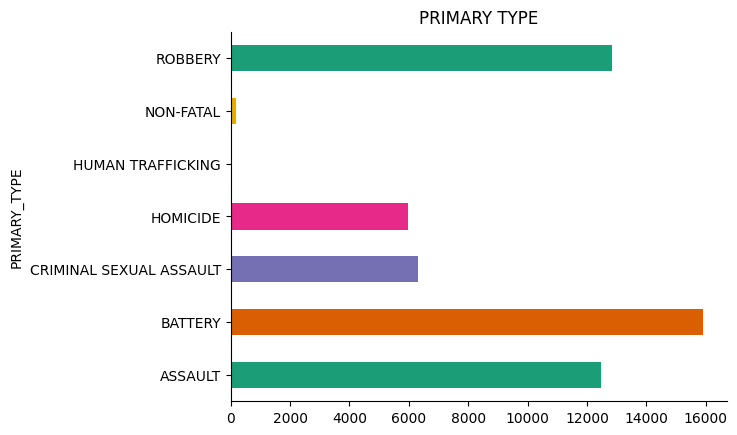

In [ ]:
dados.groupby('PRIMARY_TYPE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('PRIMARY TYPE')

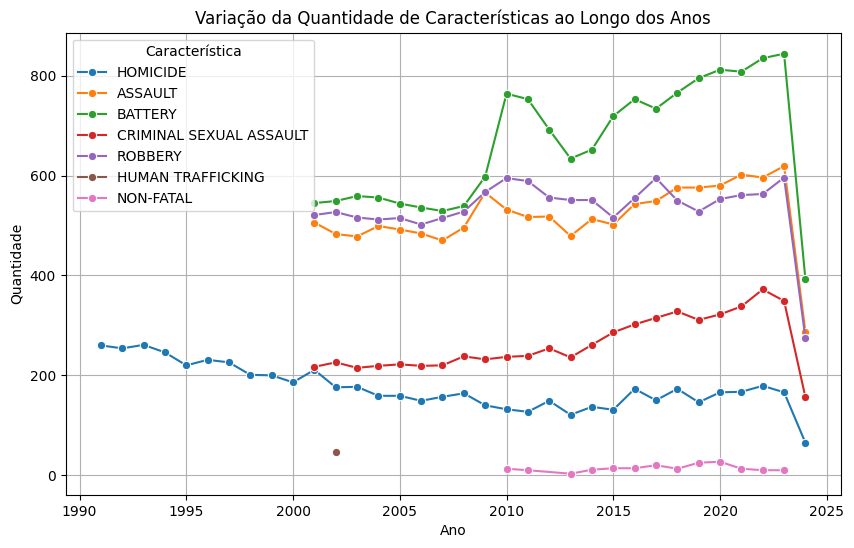

In [72]:
# Contando a quantidade de vezes que cada característica aparece por ano
dados_counts = dados.groupby(['yead', 'PRIMARY_TYPE']).size().reset_index(name='count')

# Plotando o gráfico de linhas
plt.figure(figsize=(10, 6))

# Usando seaborn para plotar
sns.lineplot(data=dados_counts, x='yead', y='count', hue='PRIMARY_TYPE', marker='o')

# Adicionando títulos e rótulos
plt.title('Variação da Quantidade de Características ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.legend(title='Característica')
plt.grid(True)

# Exibindo o gráfico
plt.show()

Text(0.5, 1.0, 'AGE')

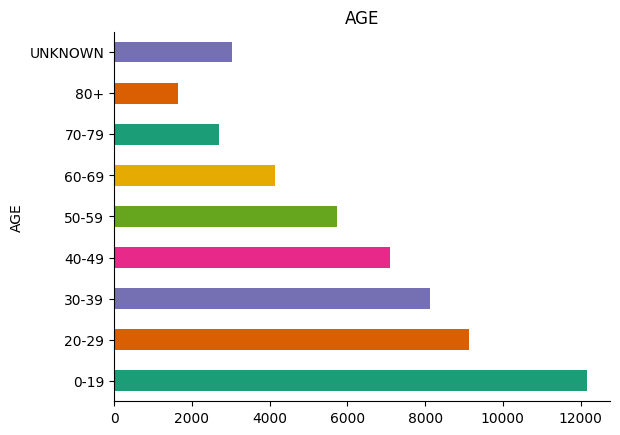

In [69]:
dados.groupby('AGE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('AGE')

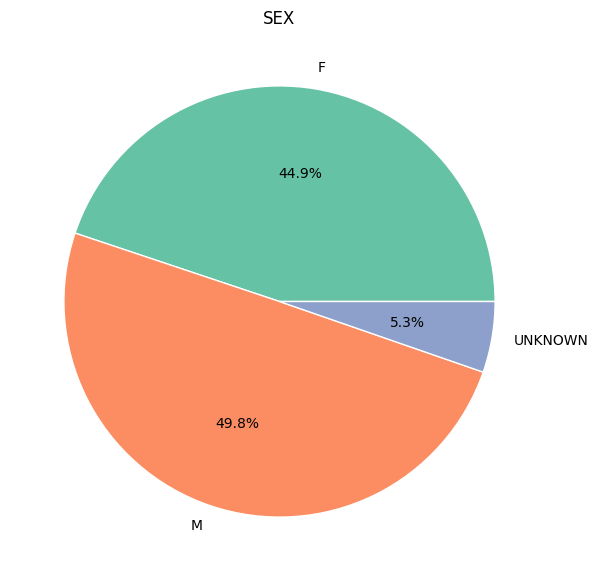

In [ ]:
dados_agrupados = dados.groupby('SEX').size()
cores = sns.color_palette('Set2', len(dados_agrupados))

plt.figure(figsize=(10, 7))
plt.pie(dados_agrupados, labels=dados_agrupados.index, autopct='%1.1f%%', colors=cores, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('SEX')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'RACE')

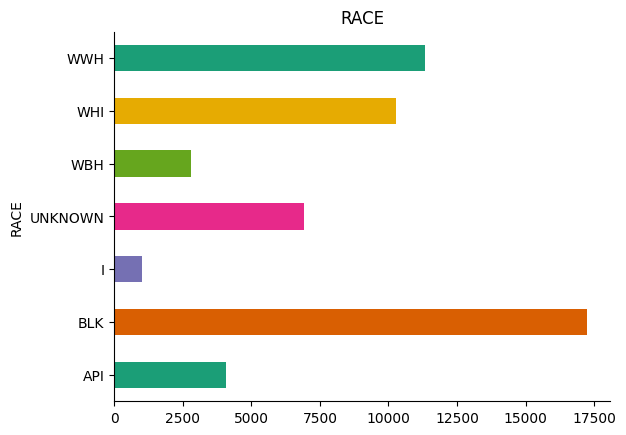

In [ ]:
dados.groupby('RACE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('RACE')

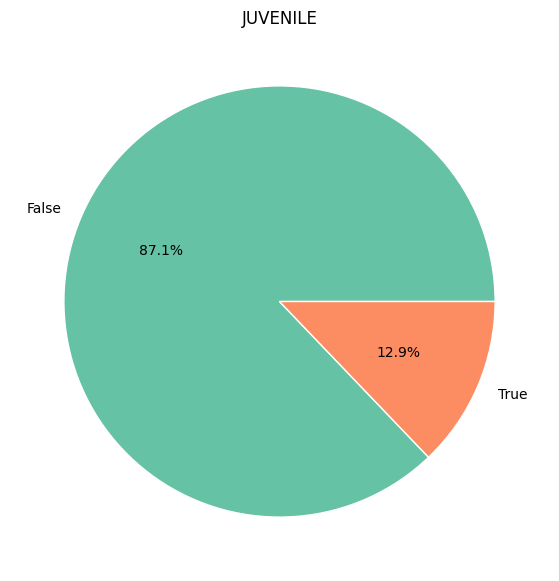

In [ ]:
dados_agrupados = dados.groupby('JUVENILE_I').size()
cores = sns.color_palette('Set2', len(dados_agrupados))

plt.figure(figsize=(10, 7))
plt.pie(dados_agrupados, labels=dados_agrupados.index, autopct='%1.1f%%', colors=cores, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('JUVENILE')
plt.axis('off')
plt.show()

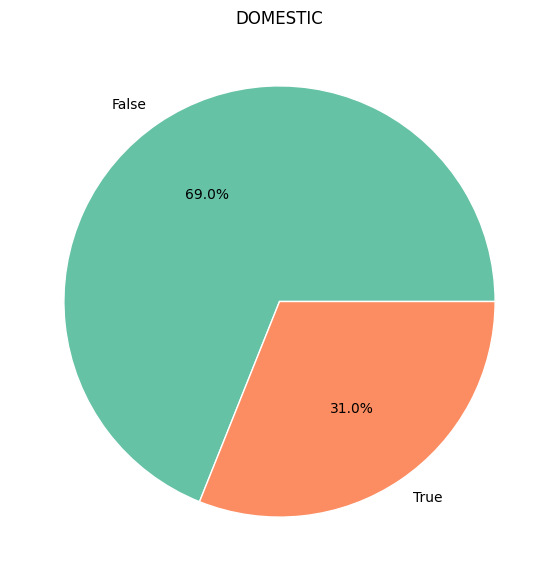

In [ ]:
dados_agrupados = dados.groupby('DOMESTIC_I').size()
cores = sns.color_palette('Set2', len(dados_agrupados))

plt.figure(figsize=(10, 7))
plt.pie(dados_agrupados, labels=dados_agrupados.index, autopct='%1.1f%%', colors=cores, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('DOMESTIC')
plt.axis('off')
plt.show()

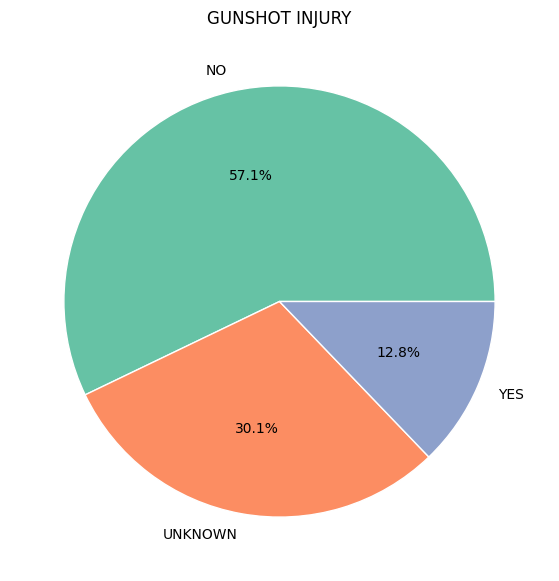

In [ ]:
dados_agrupados = dados.groupby('GUNSHOT_INJURY_I').size()
cores = sns.color_palette('Set2', len(dados_agrupados))

plt.figure(figsize=(10, 7))
plt.pie(dados_agrupados, labels=dados_agrupados.index, autopct='%1.1f%%', colors=cores, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('GUNSHOT INJURY')
plt.axis('off')
plt.show()

In [ ]:
car = dados[dados['NUMBER_OF_VICTIMS'] > 49]

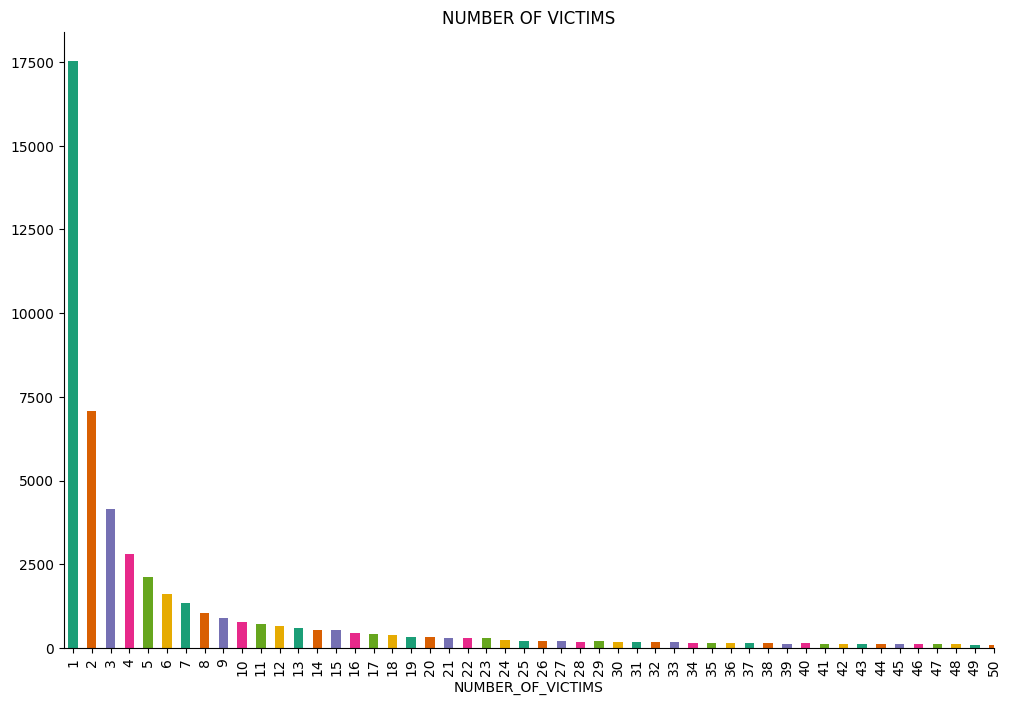

In [ ]:
# Definir o tamanho da figura
plt.figure(figsize=(12, 8))  # Altere os valores conforme necessário (largura, altura)

# Seu código para gerar o gráfico de barras
dados.groupby('NUMBER_OF_VICTIMS').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

# Ajustes nos eixos e título
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('NUMBER OF VICTIMS')

# Definindo os limites do eixo X
plt.xlim(-0.5, 49)

# Mostrando o gráfico
plt.show()

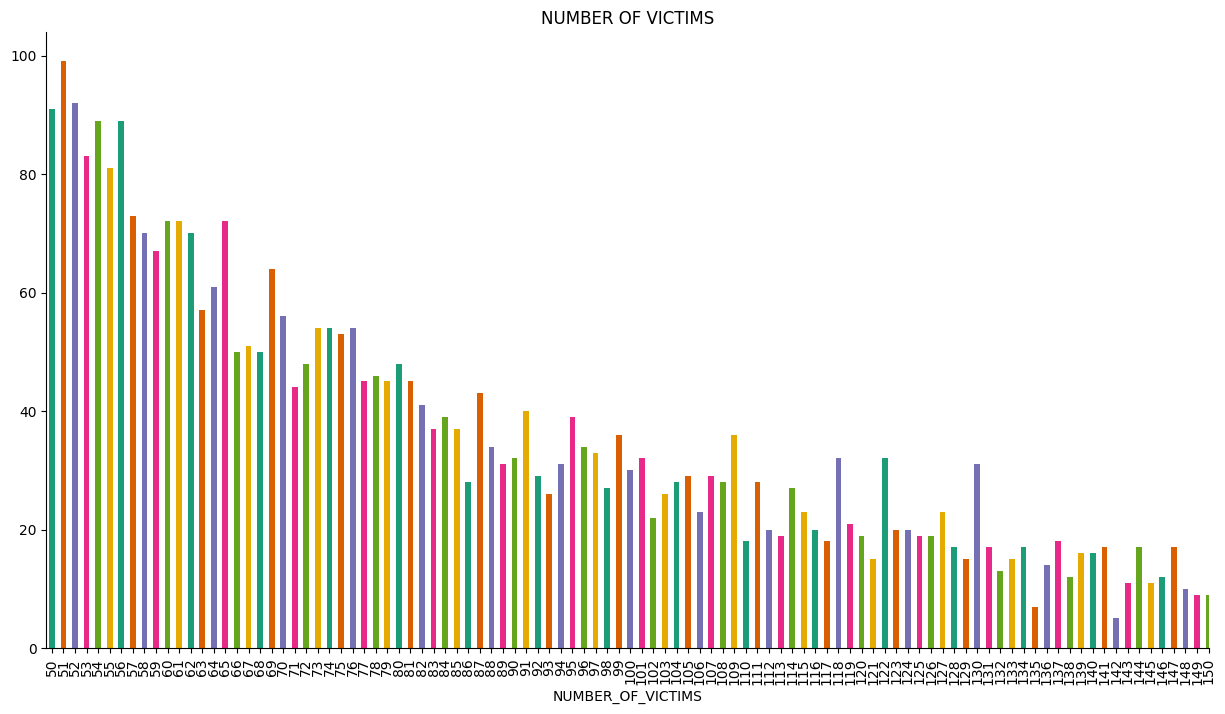

In [ ]:
# Definir o tamanho da figura
plt.figure(figsize=(15, 8))  # Altere os valores conforme necessário (largura, altura)

# Seu código para gerar o gráfico de barras
car.groupby('NUMBER_OF_VICTIMS').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

# Ajustes nos eixos e título
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('NUMBER OF VICTIMS')

# Definindo os limites do eixo X
plt.xlim(-0.5, 100)

# Mostrando o gráfico
plt.show()

In [ ]:
car = dados[dados['NUMBER_OF_VICTIMS'] > 149]

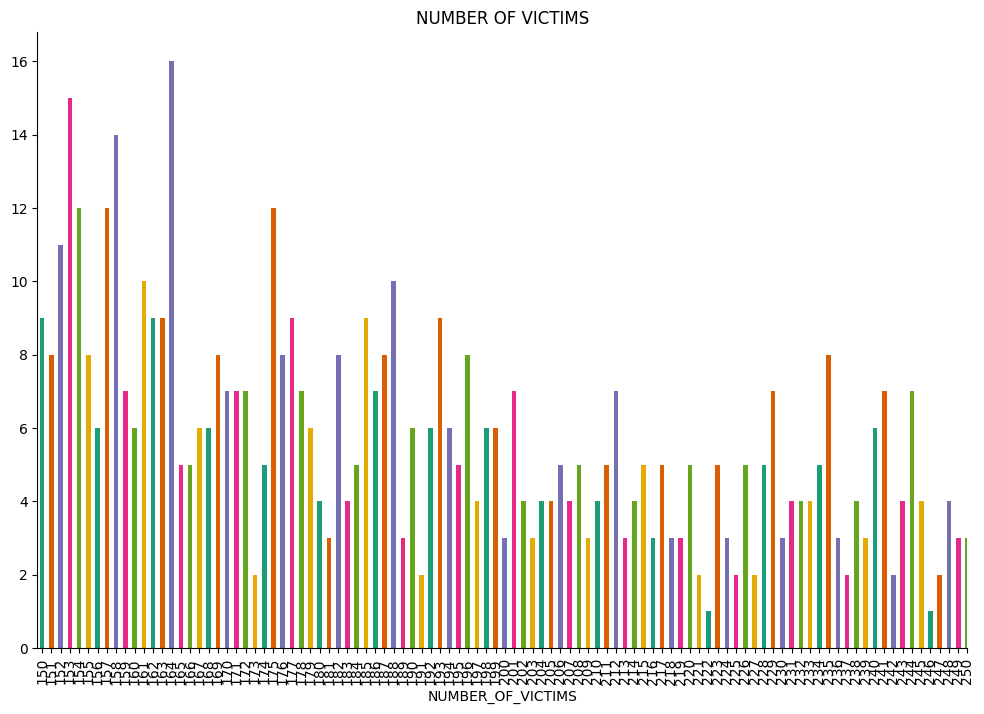

In [ ]:
# Definir o tamanho da figura
plt.figure(figsize=(12, 8))  # Altere os valores conforme necessário (largura, altura)

# Seu código para gerar o gráfico de barras
car.groupby('NUMBER_OF_VICTIMS').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

# Ajustes nos eixos e título
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('NUMBER OF VICTIMS')

# Definindo os limites do eixo X
plt.xlim(-0.5, 100)

# Mostrando o gráfico
plt.show()

In [ ]:
car = dados[dados['NUMBER_OF_VICTIMS'] > 249]

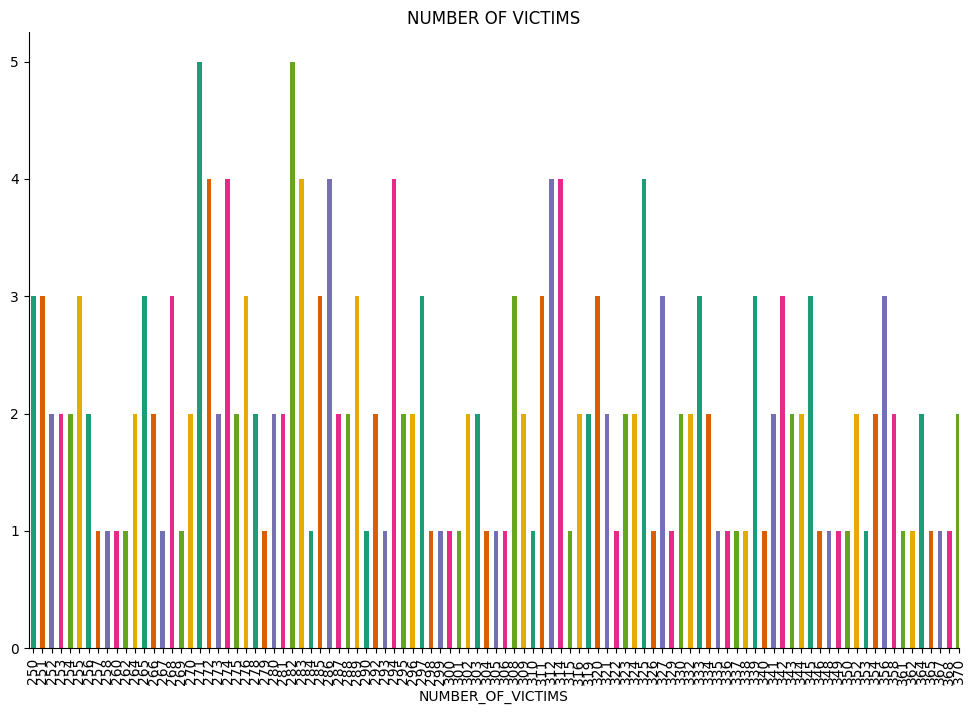

In [ ]:
# Definir o tamanho da figura
plt.figure(figsize=(12, 8))  # Altere os valores conforme necessário (largura, altura)

# Seu código para gerar o gráfico de barras
car.groupby('NUMBER_OF_VICTIMS').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

# Ajustes nos eixos e título
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('NUMBER OF VICTIMS')

# Definindo os limites do eixo X
plt.xlim(-0.5, 100)

# Mostrando o gráfico
plt.show()

In [ ]:
car = dados[dados['NUMBER_OF_VICTIMS'] > 349]

In [ ]:
# Definir o tamanho da figura
plt.figure(figsize=(12, 8))  # Altere os valores conforme necessário (largura, altura)

# Seu código para gerar o gráfico de barras
car.groupby('NUMBER_OF_VICTIMS').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

# Ajustes nos eixos e título
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('NUMBER OF VICTIMS')

# Definindo os limites do eixo X
plt.xlim(-0.5, 82)

# Mostrando o gráfico
plt.show()

In [ ]:
dados['TIME_PERIOD'].nunique()

- DENTRO DE CADA IDADE QUAIS SÃO OS CRIMES QUE MAIS OCORRE
- FAZER GRÁFICO DE EVOLUÇÃO POR TEMPO
- FAZER GRAFICO FUTURO PELO TEMPO
- JUNTAR GRAFICO DE NÚMERO DE VITIMAS, DEPOIS DO 50 JUNTANDO DE 10 EM 10